In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, TimestampType, IntegerType
from pyspark.sql.functions import from_json, col

# Define the path to the jars on the EC2 instance
spark_jars_path = "/home/ec2-user/stream-processing-template/jars"  # <-- Update this path

spark = SparkSession.builder.appName("retail_pysaprk_consumer") \
    .config("spark.jars", f"{spark_jars_path}/commons-pool2-2.11.1.jar,"
            f"{spark_jars_path}/spark-sql-kafka-0-10_2.12-3.4.0.jar,"
            f"{spark_jars_path}/spark-streaming-kafka-0-10-assembly_2.12-3.4.0.jar") \
    .getOrCreate()


23/12/13 12:18:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
# Define the schema for our data
schema = StructType([
    StructField("store_location", StringType(), True),
    StructField("time_of_purchase", TimestampType(), True),
    StructField("product_ID", StringType(), True),
    StructField("transaction_amount", IntegerType(), True)
])

# Stream from Kafka topic
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092") \
    .option("subscribe", "retail_transactions") \
    .load()

In [3]:
transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*"))

query = transactions.writeStream \
.format("memory") \
.queryName("temporary_view_one") \
.start()

query.awaitTermination(15)

23/12/13 12:18:35 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-97624c1c-9cdd-4bd8-8a81-ae2162b13186. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/13 12:18:35 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/12/13 12:18:38 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [4]:
processed_data = spark.sql("SELECT * FROM temporary_view_one")
processed_data.show()

+--------------+-------------------+----------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|
+--------------+-------------------+----------+------------------+
|       Chicago|2023-12-13 12:18:39|    P00046|               306|
|       Phoenix|2023-12-13 12:18:41|    P00052|               452|
|       Chicago|2023-12-13 12:18:43|    P00058|               527|
|       Chicago|2023-12-13 12:18:46|    P00012|               426|
|       Phoenix|2023-12-13 12:18:48|    P00092|               621|
|       Houston|2023-12-13 12:18:51|    P00054|               775|
+--------------+-------------------+----------+------------------+



In [5]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import sum, avg, dayofyear, hour

transactions = processed_data.withColumn("transaction_amount", col("transaction_amount").cast(DoubleType()))

In [37]:
transactions.count()

6985

# Transformations
Aggregations:
- Total transaction amounts by store location
- Number of transactions by store location
- Average transation amount by store location

In [38]:
total_transactions = transactions.groupBy("store_location").agg(sum("transaction_amount").alias("total_amount"))
total_transactions.show()

+--------------+------------+
|store_location|total_amount|
+--------------+------------+
|       Phoenix|    442452.0|
|   San Antonio|    424024.0|
|  Philadelphia|    467557.0|
|   Los Angeles|    460512.0|
|       Chicago|    445426.0|
|       Houston|    468806.0|
|      New York|    444183.0|
+--------------+------------+



In [39]:
transaction_counts = transactions.groupBy("store_location").count().withColumnRenamed("count", "transaction_count")
transaction_counts.show()

+--------------+-----------------+
|store_location|transaction_count|
+--------------+-----------------+
|       Phoenix|              970|
|   San Antonio|              981|
|  Philadelphia|             1015|
|   Los Angeles|              999|
|       Chicago|              992|
|       Houston|             1039|
|      New York|              989|
+--------------+-----------------+



In [40]:
average_transactions = transactions.groupBy("store_location").agg(avg("transaction_amount").alias("average_amount"))
average_transactions.show()

+--------------+------------------+
|store_location|    average_amount|
+--------------+------------------+
|       Phoenix| 456.1360824742268|
|   San Antonio| 432.2364933741081|
|  Philadelphia| 460.6472906403941|
|   Los Angeles|460.97297297297297|
|       Chicago| 449.0181451612903|
|       Houston|451.20885466794994|
|      New York| 449.1233569261881|
+--------------+------------------+



Time Series Analysis
- Transactions per hour/day to understand peak sales times
- Total or average transactions amounts over time

In [41]:
transactions_per_hour_per_day = transactions.withColumn("day", dayofyear(transactions["time_of_purchase"])).withColumn("hour", hour(transactions["time_of_purchase"]))
daily_hourly_row_count = transactions_per_hour_per_day.groupBy("day", "hour").count().orderBy("day", "hour")
hourly_total_transactions = transactions_per_hour_per_day.groupBy("day", "hour").agg(sum("transaction_amount").alias("total_transactions_hourly"))
hourly_avg_transaction_amount = transactions_per_hour_per_day.groupBy("day", "hour").agg(avg("transaction_amount").alias("avg_transaction_amount_hourly"))
combined_data = daily_hourly_row_count.join(hourly_total_transactions, ['day', 'hour'], "left_outer") \
    .join(hourly_avg_transaction_amount, ['day', 'hour'], "left_outer") \
    .orderBy("day", "hour")
combined_data.show()

+---+----+-----+-------------------------+-----------------------------+
|day|hour|count|total_transactions_hourly|avg_transaction_amount_hourly|
+---+----+-----+-------------------------+-----------------------------+
|347|  12| 1255|                 569136.0|           453.49482071713146|
|347|  13| 1782|                 800566.0|            449.2514029180696|
|347|  14| 1801|                 826169.0|            458.7279289283731|
|347|  15| 1783|                 804968.0|            451.4683118339877|
|347|  16|  364|                 152121.0|           417.91483516483515|
+---+----+-----+-------------------------+-----------------------------+



## Exercise One

In [43]:
with_discount = transactions.withColumn("discounted_amount", col("transaction_amount") * 0.9)
with_discount.show()

+--------------+-------------------+----------+------------------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount| discounted_amount|
+--------------+-------------------+----------+------------------+------------------+
|       Chicago|2023-12-13 12:18:39|    P00046|             306.0|275.40000000000003|
|       Phoenix|2023-12-13 12:18:41|    P00052|             452.0|             406.8|
|       Chicago|2023-12-13 12:18:43|    P00058|             527.0|             474.3|
|       Chicago|2023-12-13 12:18:46|    P00012|             426.0|383.40000000000003|
|       Phoenix|2023-12-13 12:18:48|    P00092|             621.0|             558.9|
|       Houston|2023-12-13 12:18:51|    P00054|             775.0|             697.5|
|      New York|2023-12-13 12:18:53|    P00003|             529.0|             476.1|
|      New York|2023-12-13 12:18:56|    P00077|             834.0|             750.6|
|       Houston|2023-12-13 12:18:59|    P00085|       

In [47]:
physical_transactions = with_discount.filter(with_discount.store_location != "online")

# Plots

<Figure size 1200x600 with 0 Axes>

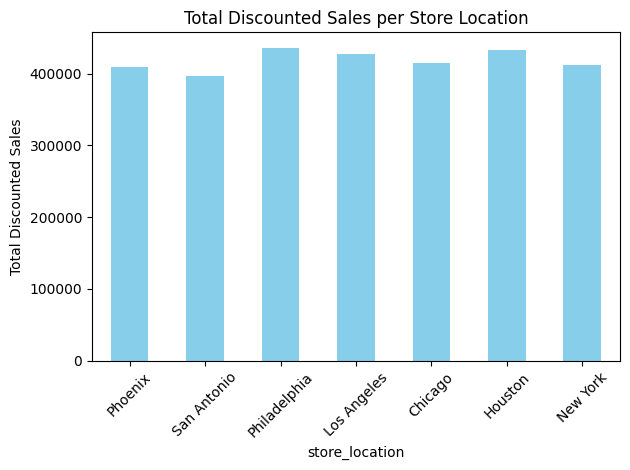

In [49]:

# Grouping and Aggregating
store_sales = physical_transactions.groupBy("store_location") \
    .agg(sum("discounted_amount").alias("total_sales"))

# Convert to Pandas DataFrame for plotting
store_sales_pd = store_sales.toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
store_sales_pd.plot(kind='bar', x='store_location', y='total_sales', legend=False, color='skyblue')
plt.ylabel('Total Discounted Sales')
plt.title('Total Discounted Sales per Store Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()